#Requirements

In [1]:
!pip install pygambit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.6/631.6 KB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygambit: filename=pygambit-16.0.2-cp38-cp38-linux_x86_64.whl size=10629933 sha256=0bc1d068939937a0e4fe5ccad9b88b77f8a6aa6f27dbf104d35f9ec84b072356
  Stored in directory: /root/.cache/pip/wheels/e9/c7/0a/2ee3562b1658987228fd2b3ff90d59b529da50914ceff6a849
Successfully built pygambit


#Imports

In [2]:
import pygambit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

#Utility Function

In [3]:
def Utilities(Lambda, Beta, C, a, Mio=1):
  '''
    Computes the corresponding utilities to the transmitter and 
    eavesdropper for a two-player game.
  '''
  scale_up_coefficient = 1e16
  ro = Lambda / Mio
  AoI_E = 1 + 1/(Beta*ro) + (Beta**2 * ro**2)/(1-Beta*ro)
  AoI_R = 1 + 1/ro + (ro**2)/(1-ro)
  U_T = AoI_E / (AoI_R**(a+1)) - C*Lambda
  U_E = 1/AoI_E - C*Beta 
  return (int(U_T*scale_up_coefficient), int(U_E*scale_up_coefficient)) #Gambit requires precisely-specified data for payoffs; floating-point data can never be used.

#Parameter Discritization

In [4]:
lambdas = [i/100 for i in range(1, 54)]#Lambda* must be lower than 0.531
betas = [i/100 for i in range(1,101)]#Beta* might be any value of interval (0, 1]
a_s = [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
c_s = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]
#These values might change

#Game

In [5]:
def Game(lambdas, betas, C, a, utility_fun,  title, player1, player2):
  '''
    This function create the corresponding game to player1 and player2, according to
    their strategies and other parameters, including a and C.
  '''
  strategy_dim = [len(lambdas), len(betas)]
  g = pygambit.Game.new_table(strategy_dim)
  g.title = title
  g.players[0].label = player1
  g.players[1].label = player2

  for i, L in enumerate(lambdas):
    g.players[0].strategies[i].label = f"Lambda:{L}"
  for j, B in enumerate(betas):
    g.players[1].strategies[j].label = f"Beta:{B}"

  for i, L in enumerate(lambdas):
    for j, B in enumerate(betas):
      g[i,j][0], g[i,j][1] = utility_fun(Lambda=L, Beta=B, C=C, a=a)

  return g

#Test1  
title = "Two-player game of AoI"        
player1 = "transmitter"
player2 = "eavesdropper"
Game(lambdas=[0.1, 0.2], betas=[0.25, 0.45], C=0.2, a=0, utility_fun=Utilities,  title=title, player1=player1, player2=player2)

NFG 1 R "Two-player game of AoI" { "transmitter" "eavesdropper" }

{ { "Lambda:0.1" "Lambda:0.2" }
{ "Beta:0.25" "Beta:0.45" }
}
""

{
{ "" 37035698206939376, -256101374274948 }
{ "" 34315093518921272, -23869189324646 }
{ "" 20891733982808628, -469417306894370 }
{ "" 19633078033078028, -74918322958527 }
}
1 2 3 4 

In [6]:
#Test2
title = "Two-player game of AoI"        
player1 = "transmitter"
player2 = "eavesdropper"
C = c_s[0]
a = a_s[0]
Game(lambdas=lambdas, betas=betas, C=C, a=a, utility_fun=Utilities,  title=title, player1=player1, player2=player2)
#len(lambdas) * len(betas) = 53 * 100 = 5300 Grids

NFG 1 R "Two-player game of AoI" { "transmitter" "eavesdropper" }

{ { "Lambda:0.01" "Lambda:0.02" "Lambda:0.03" "Lambda:0.04" "Lambda:0.05" "Lambda:0.06" "Lambda:0.07" "Lambda:0.08" "Lambda:0.09" "Lambda:0.1" "Lambda:0.11" "Lambda:0.12" "Lambda:0.13" "Lambda:0.14" "Lambda:0.15" "Lambda:0.16" "Lambda:0.17" "Lambda:0.18" "Lambda:0.19" "Lambda:0.2" "Lambda:0.21" "Lambda:0.22" "Lambda:0.23" "Lambda:0.24" "Lambda:0.25" "Lambda:0.26" "Lambda:0.27" "Lambda:0.28" "Lambda:0.29" "Lambda:0.3" "Lambda:0.31" "Lambda:0.32" "Lambda:0.33" "Lambda:0.34" "Lambda:0.35" "Lambda:0.36" "Lambda:0.37" "Lambda:0.38" "Lambda:0.39" "Lambda:0.4" "Lambda:0.41" "Lambda:0.42" "Lambda:0.43" "Lambda:0.44" "Lambda:0.45" "Lambda:0.46" "Lambda:0.47" "Lambda:0.48" "Lambda:0.49" "Lambda:0.5" "Lambda:0.51" "Lambda:0.52" "Lambda:0.53" }
{ "Beta:0.01" "Beta:0.02" "Beta:0.03" "Beta:0.04" "Beta:0.05" "Beta:0.06" "Beta:0.07" "Beta:0.08" "Beta:0.09" "Beta:0.1" "Beta:0.11" "Beta:0.12" "Beta:0.13" "Beta:0.14" "Beta:0.15" "Beta:0.1

#Game Solving

In [7]:
def NE_interpreter(NEs, str_pl1=lambdas, str_pl2=betas):
  '''
    This function converts the NEs produced by the solver to its corresponding
    values of lambda* and beta*. 
  '''
  results = []

  for ind, NE in enumerate(NEs):

    LAM_STAR, BET_STAR = 0, 0
    for i, p in enumerate(NE):

      if i < len(str_pl1):
        LAM_STAR += lambdas[i] * p
      else:
        BET_STAR += betas[i-len(str_pl1)] * p

    results.append([f'NE{ind+1}', LAM_STAR, BET_STAR])

  return results

def NE_Solver(g):
  '''
    This function receives a game as the input and finds its corresponding
    NE. It then interprets the NE as a pair (Lambda_Star, Beta_Star), using
    UNKNOWN function. (Should be adjusted...)
  '''
  NEs = pygambit.nash.enumpure_solve(g, use_strategic=True)
  LAM_BET_STARS = NE_interpreter(NEs)
  return LAM_BET_STARS

In [8]:
results = {}
for a in tqdm(a_s):
  for C in tqdm(c_s):
    g = Game(lambdas=lambdas, betas=betas, C=C, a=a, utility_fun=Utilities, title=title, player1=player1, player2=player2)
    lam_bet_stars = NE_Solver(g)
    results.setdefault((a, C), lam_bet_stars)

100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


In [32]:
results

{(0, 0): [['NE1', 0.01, 1.0],
  ['NE2', 0.02, 1.0],
  ['NE3', 0.03, 1.0],
  ['NE4', 0.04, 1.0],
  ['NE5', 0.05, 1.0],
  ['NE6', 0.06, 1.0],
  ['NE7', 0.07, 1.0],
  ['NE8', 0.08, 1.0],
  ['NE9', 0.09, 1.0],
  ['NE10', 0.1, 1.0],
  ['NE11', 0.11, 1.0],
  ['NE12', 0.12, 1.0],
  ['NE13', 0.13, 1.0],
  ['NE14', 0.14, 1.0],
  ['NE15', 0.15, 1.0],
  ['NE16', 0.16, 1.0],
  ['NE17', 0.17, 1.0],
  ['NE18', 0.18, 1.0],
  ['NE19', 0.19, 1.0],
  ['NE20', 0.2, 1.0],
  ['NE21', 0.21, 1.0],
  ['NE22', 0.22, 1.0],
  ['NE23', 0.23, 1.0],
  ['NE24', 0.24, 1.0],
  ['NE25', 0.25, 1.0],
  ['NE26', 0.26, 1.0],
  ['NE27', 0.27, 1.0],
  ['NE28', 0.28, 1.0],
  ['NE29', 0.29, 1.0],
  ['NE30', 0.3, 1.0],
  ['NE31', 0.31, 1.0],
  ['NE32', 0.32, 1.0],
  ['NE33', 0.33, 1.0],
  ['NE34', 0.34, 1.0],
  ['NE35', 0.35, 1.0],
  ['NE36', 0.36, 1.0],
  ['NE37', 0.37, 1.0],
  ['NE38', 0.38, 1.0],
  ['NE39', 0.39, 1.0],
  ['NE40', 0.4, 1.0],
  ['NE41', 0.41, 1.0],
  ['NE42', 0.42, 1.0],
  ['NE43', 0.43, 1.0],
  ['NE44', 0.44,

#Visualization

In [14]:
def plot_beta_lambda_a(results, C):
  color_dic = {}
  color_list = ['b', 'r', 'g', 'c', 'm', 'yellow', 'k', 'thistle', 'peru', 'olive', 'dodgerblue']
  LAMS, BETS, AS = [], [], []
  for key in results:
    if key[1] == C:
      AS.append(key[0])
      color_dic.setdefault(AS[-1], color_list[a_s.index(AS[-1])])
      value = results[key]
      if len(value) == 0:
        LAMS.append('x')
        BETS.append('x')
        scatter = plt.scatter(-0.1, -0.1, label=AS[-1], s=50, marker='x', c='black')
      else: 
        mult_lam = []
        mult_bet = []
        j = 0
        for v in value:  
          mult_lam.append(v[1])
          mult_bet.append(v[2])
          if j == 0:
            scatter = plt.scatter(mult_lam[-1], mult_bet[-1], label=AS[-1], s=50, c=color_dic[AS[-1]])
          else:
            scatter = plt.scatter(mult_lam[-1], mult_bet[-1], s=50, c=color_dic[AS[-1]])
          j += 1
        LAMS.append(mult_lam)
        BETS.append(mult_bet)
  print('lambdas:', LAMS)
  print('betas:', BETS)
  print('as:', AS)
  plt.title(f"NE s for a fixed value of C={C} and different values of a")
  plt.xlabel("$\lambda^*$")
  plt.ylabel("$\\beta^*$")
  plt.xlim((-0.2,0.6))
  plt.ylim((-0.2,1.1))
  plt.legend(bbox_to_anchor=(1.2, 1.0), title="a")
  plt.grid()
  plt.show()

lambdas: [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53], [0.53], [0.53], [0.53], [0.53], [0.53], [0.53], [0.53], [0.53], [0.53], [0.53]]
betas: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


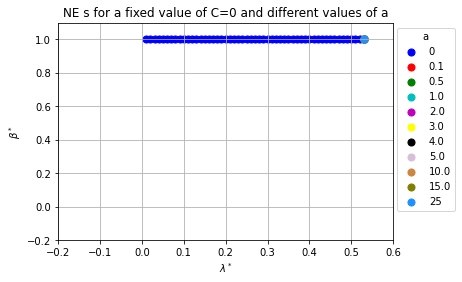

lambdas: [[0.01], [0.1, 0.4], [0.46], [0.47], [0.46], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01, 1.0], [0.97], [0.95], [0.97], [0.36], [0.8], [0.02], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


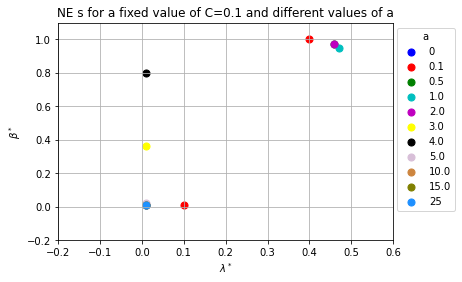

lambdas: [[0.01], [0.1], [0.36, 0.37], [0.41], [0.37], [0.39], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.75, 0.76], [0.76], [0.76], [0.16], [0.3], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


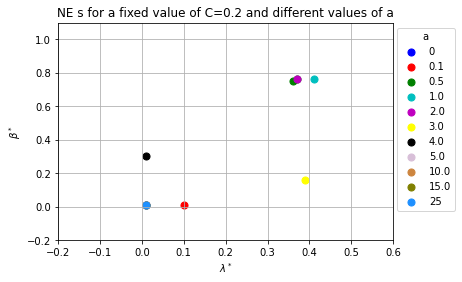

lambdas: [[0.01], [0.1], [0.31], [0.38], [0.38], [0.39], [0.43], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.05], [0.32], [0.32], [0.1], [0.2], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


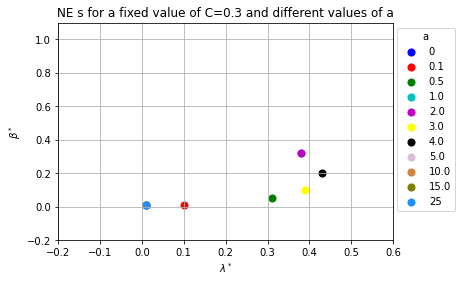

lambdas: [[0.01], [0.1], [0.31], [0.39], [0.43], [0.42], [0.43], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.14], [0.06], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


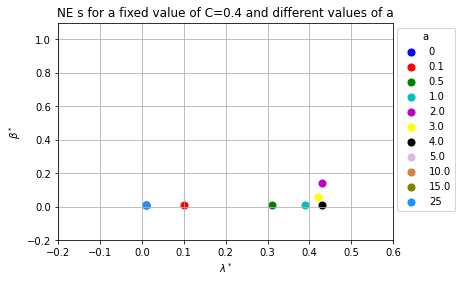

lambdas: [[0.01], [0.1], [0.31], [0.39], [0.44], [0.46], [0.45], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


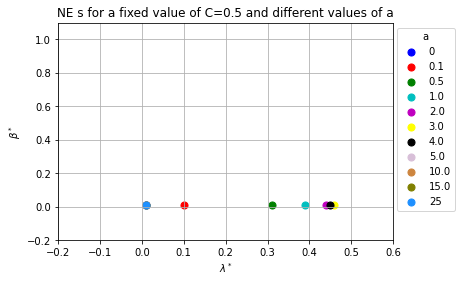

lambdas: [[0.01], [0.1], [0.31], [0.39], [0.44], [0.46], [0.45], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


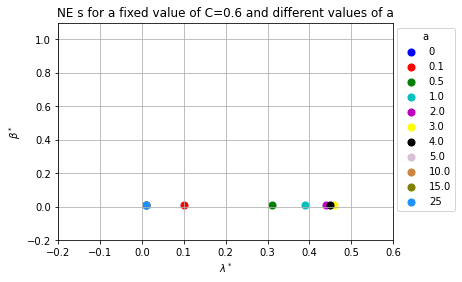

lambdas: [[0.01], [0.1], [0.3], [0.39], [0.44], [0.45], [0.43], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


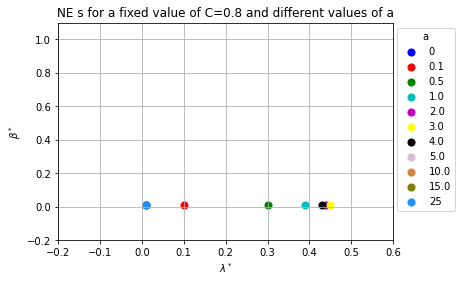

lambdas: [[0.01], [0.1], [0.3], [0.39], [0.44], [0.45], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


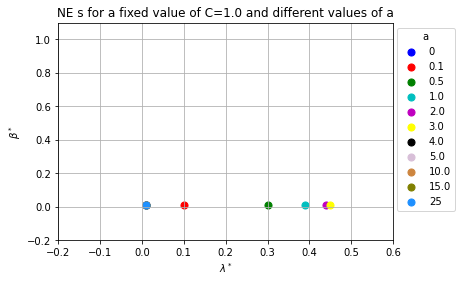

lambdas: [[0.01], [0.09], [0.29], [0.37], [0.41], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


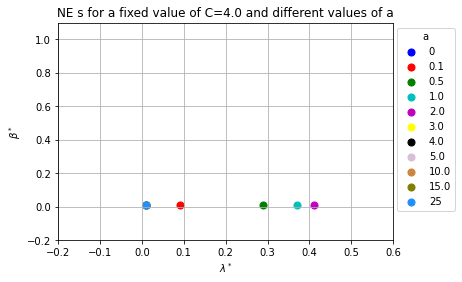

lambdas: [[0.01], [0.09], [0.28], [0.35], [0.37], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


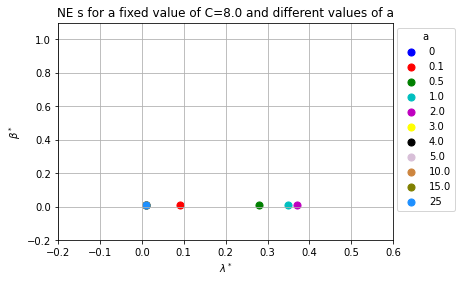

lambdas: [[0.01], [0.09], [0.27], [0.35], [0.34], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
as: [0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]


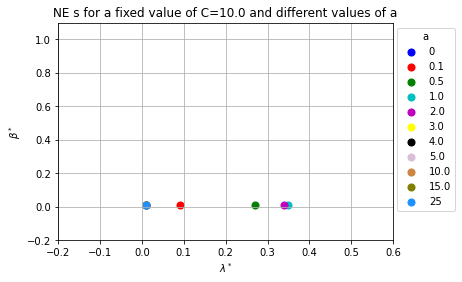

In [15]:
for C in c_s:
  plot_beta_lambda_a(results=results, C=C)

In [16]:
def plot_beta_lambda_C(results, a):
  color_dic = {}
  color_list = ['b', 'r', 'g', 'c', 'm', 'yellow', 'k', 'thistle', 'peru', 'olive', 'dodgerblue', 'gold']
  LAMS, BETS, CS = [], [], []
  for key in results:
    if key[0] == a:
      CS.append(key[1])
      color_dic.setdefault(CS[-1], color_list[c_s.index(CS[-1])])
      value = results[key]
      if len(value) == 0:
        LAMS.append('x')
        BETS.append('x')
        scatter = plt.scatter(-0.1, -0.1, label=CS[-1], s=50, marker='x', c='black')
      else: 
        mult_lam = []
        mult_bet = []
        j = 0
        for v in value:  
          mult_lam.append(v[1])
          mult_bet.append(v[2])
          if j == 0:
            scatter = plt.scatter(mult_lam[-1], mult_bet[-1], label=CS[-1], s=50, c=color_dic[CS[-1]])
          else:
            scatter = plt.scatter(mult_lam[-1], mult_bet[-1], s=50, c=color_dic[CS[-1]])
          j += 1
        LAMS.append(mult_lam)
        BETS.append(mult_bet)
  print('lambdas:', LAMS)
  print('betas:', BETS)
  print('cs:', CS)
  plt.title(f"NE s for a fixed value of a={a} and different values of C")
  plt.xlabel("$\lambda^*$")
  plt.ylabel("$\\beta^*$")
  plt.xlim((-0.2,0.6))
  plt.ylim((-0.2,1.1))
  plt.legend(bbox_to_anchor=(1.2, 1.0), title="c")
  plt.grid()
  plt.show()

lambdas: [[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


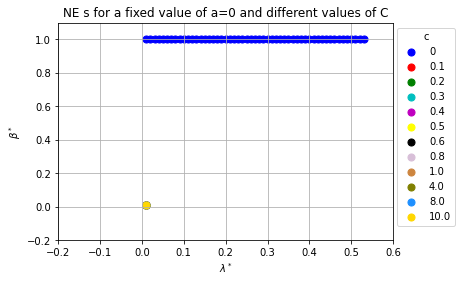

lambdas: [[0.53], [0.1, 0.4], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.1], [0.09], [0.09], [0.09]]
betas: [[1.0], [0.01, 1.0], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


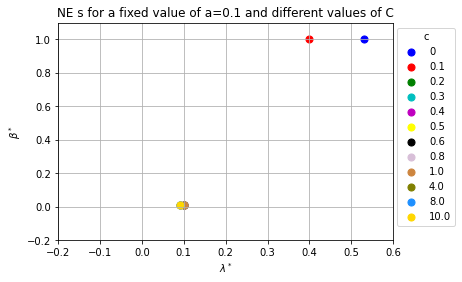

lambdas: [[0.53], [0.46], [0.36, 0.37], [0.31], [0.31], [0.31], [0.31], [0.3], [0.3], [0.29], [0.28], [0.27]]
betas: [[1.0], [0.97], [0.75, 0.76], [0.05], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


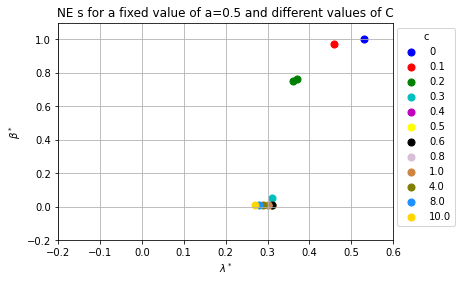

lambdas: [[0.53], [0.47], [0.41], [0.38], [0.39], [0.39], [0.39], [0.39], [0.39], [0.37], [0.35], [0.35]]
betas: [[1.0], [0.95], [0.76], [0.32], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


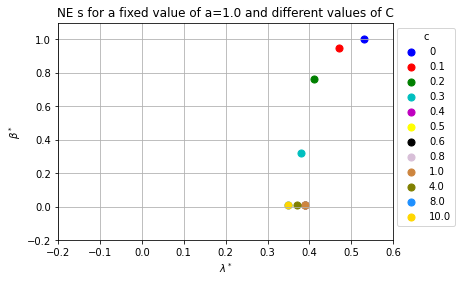

lambdas: [[0.53], [0.46], [0.37], [0.38], [0.43], [0.44], [0.44], [0.44], [0.44], [0.41], [0.37], [0.34]]
betas: [[1.0], [0.97], [0.76], [0.32], [0.14], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


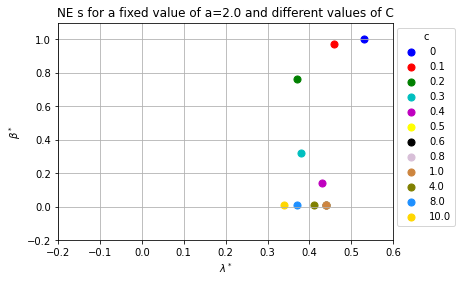

lambdas: [[0.53], [0.01], [0.39], [0.39], [0.42], [0.46], [0.46], [0.45], [0.45], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.36], [0.16], [0.1], [0.06], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


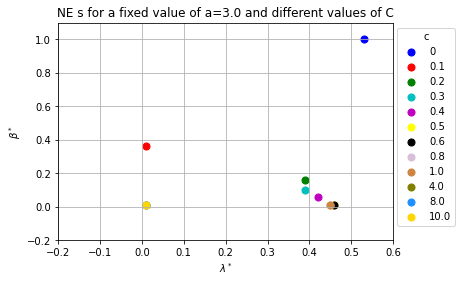

lambdas: [[0.53], [0.01], [0.01], [0.43], [0.43], [0.45], [0.45], [0.43], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.8], [0.3], [0.2], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


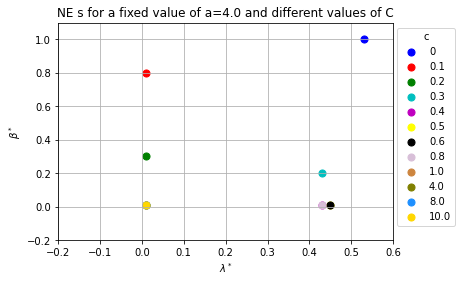

lambdas: [[0.53], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.02], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


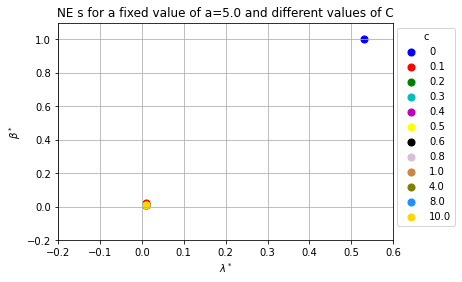

lambdas: [[0.53], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


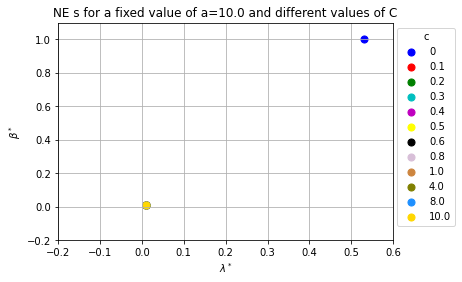

lambdas: [[0.53], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


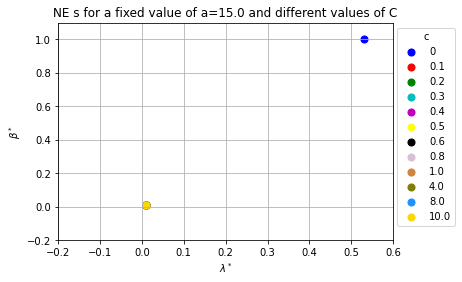

lambdas: [[0.53], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
betas: [[1.0], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01], [0.01]]
cs: [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 4.0, 8.0, 10.0]


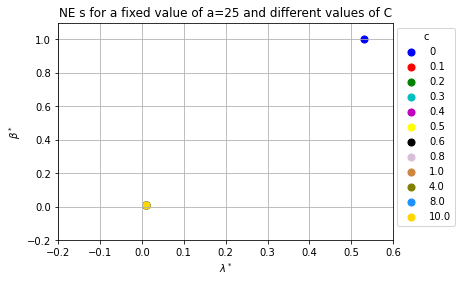

In [17]:
for a in a_s:
  plot_beta_lambda_C(results=results, a=a)

In [18]:
def plot_a_lambda_C(results, C):
  LAMS, AS = [], []
  for key in results:
    if key[1] == C:
      value = results[key]
      for v in value:
        LAMS.append(v[1])
        AS.append(key[0])
  return (AS, LAMS)

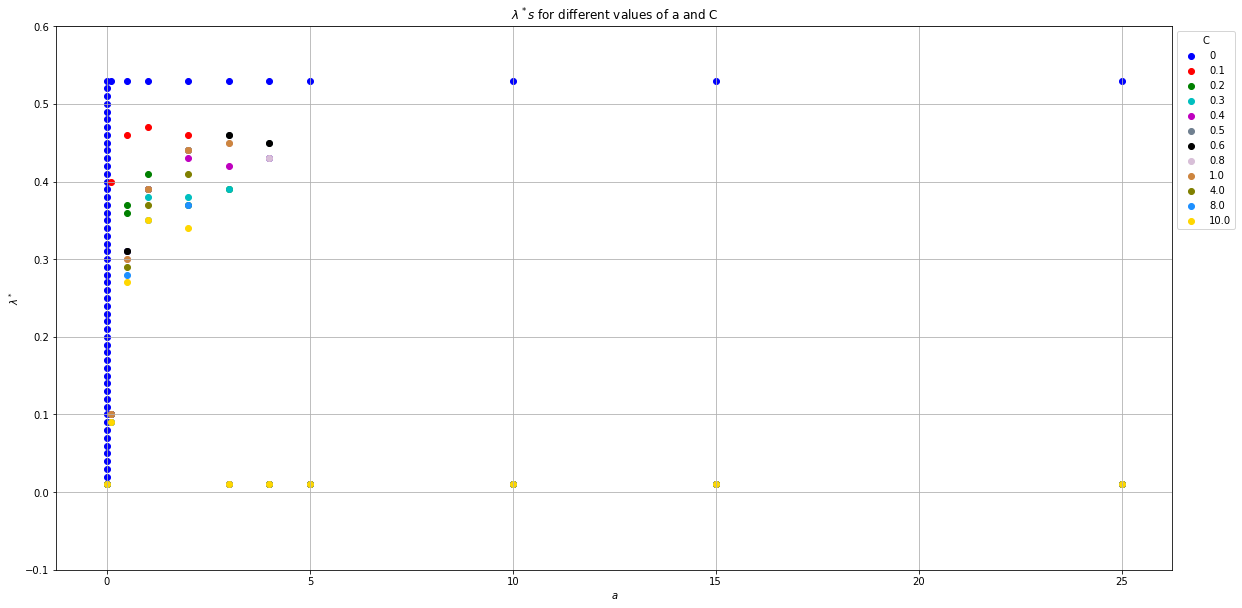

In [19]:
plt.figure(figsize=(20, 10))
color_list = ['b', 'r', 'g', 'c', 'm', 'slategrey', 'k', 'thistle', 'peru', 'olive', 'dodgerblue', 'gold']
for i, C in enumerate(c_s):
  As, Lams = plot_a_lambda_C(results=results, C=C)
  plt.scatter(As, Lams, label=C, c=color_list[i])
plt.legend(title='C',bbox_to_anchor=(1.0, 1.0))
plt.title(f"$\lambda^*s$ for different values of a and C")
plt.xlabel("$a$")
plt.ylabel("$\lambda^*$")
plt.ylim((-0.1, 0.6))
plt.grid()
plt.show()
plt.show()

C =  0
lambdas:  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53]
as:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
--------------------------------------------------
C =  0.1
lambdas:  [0.01, 0.1, 0.4, 0.46, 0.47, 0.46, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
as:  [0, 0.1, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
--------------------------------------------------
C =  0.2
lambdas:  [0.01, 0.1, 0.36, 0.37, 0.41, 0.37, 0.39, 0.01, 0.01, 0.01, 0.01, 0.01]
as:  [0, 0.1, 0.5, 0.5, 1.0, 2.0, 3.0, 4.0, 5

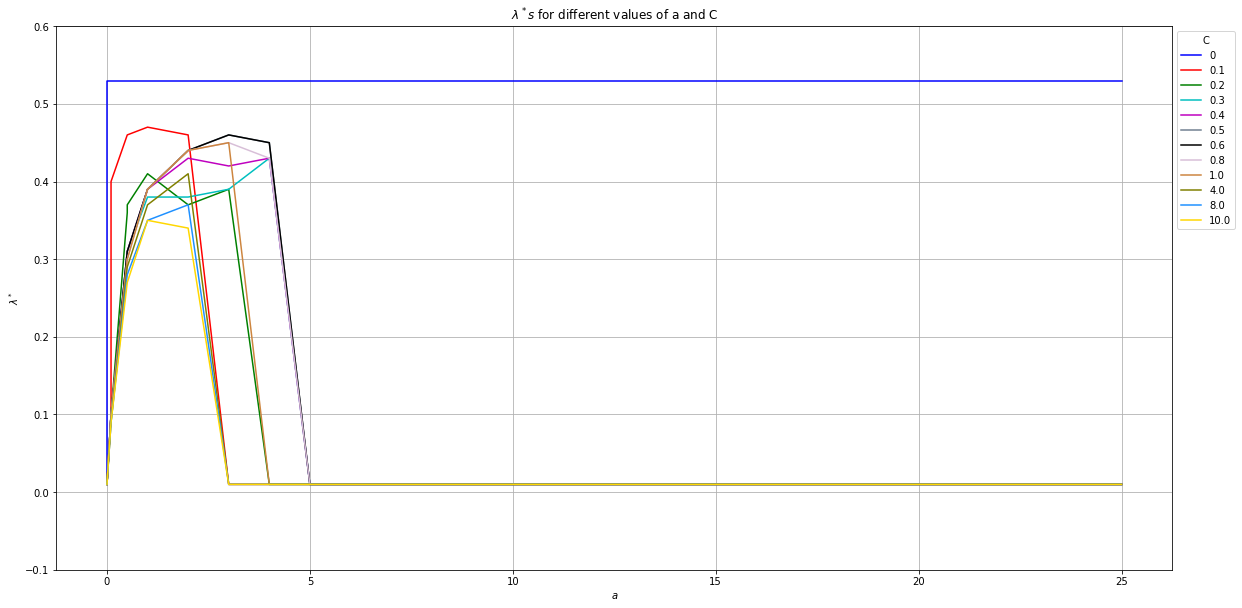

In [31]:
plt.figure(figsize=(20, 10))
color_list = ['b', 'r', 'g', 'c', 'm', 'slategrey', 'k', 'thistle', 'peru', 'olive', 'dodgerblue', 'gold']
for i, C in enumerate(c_s):
  As, Lams = plot_a_lambda_C(results=results, C=C)
  plt.plot(As, Lams, label=C, c=color_list[i])
  print('C = ', C)
  print('lambdas: ', Lams)
  print('as: ', As)
  print('-'*50)
  
plt.legend(title='C',bbox_to_anchor=(1.0, 1.0))
plt.title(f"$\lambda^*s$ for different values of a and C")
plt.xlabel("$a$")
plt.ylabel("$\lambda^*$")
plt.ylim((-0.1, 0.6))
plt.grid()
plt.show()
plt.show()

In [21]:
def plot_a_beta_C(results, C):
  BETS, AS = [], []
  for key in results:
    if key[1] == C:
      value = results[key]
      for v in value:
        BETS.append(v[2])
        AS.append(key[0])
  return (AS, BETS)

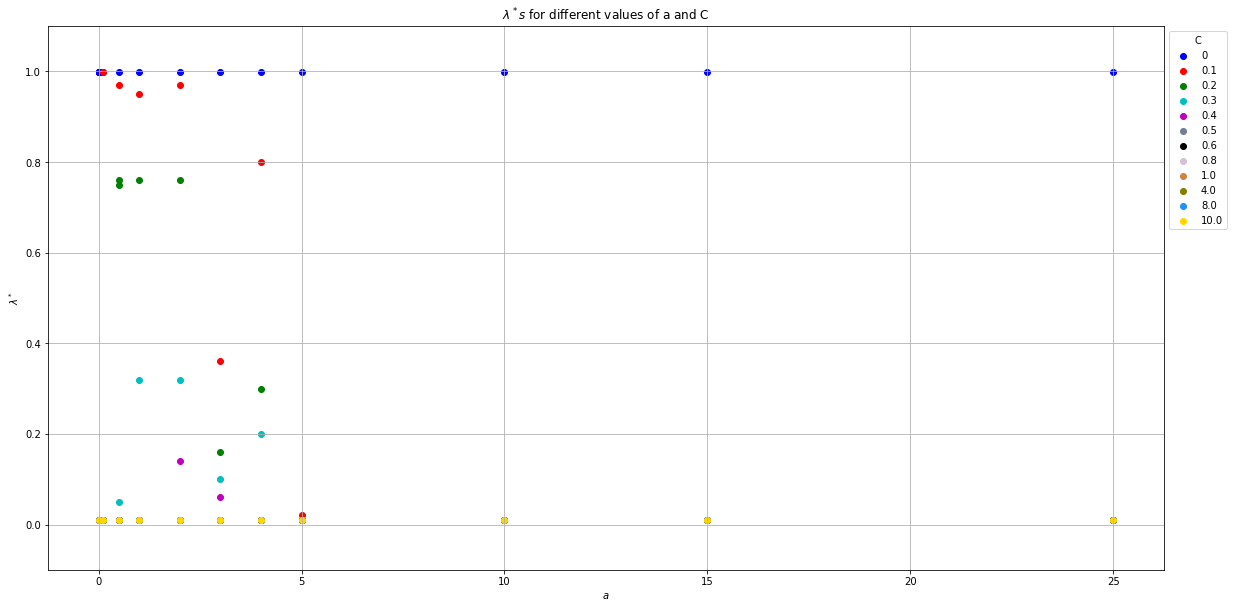

In [22]:
plt.figure(figsize=(20, 10))
color_list = ['b', 'r', 'g', 'c', 'm', 'slategrey', 'k', 'thistle', 'peru', 'olive', 'dodgerblue', 'gold']
for i, C in enumerate(c_s):
  As, Bets = plot_a_beta_C(results=results, C=C)
  plt.scatter(As, Bets, label=C, c=color_list[i])
plt.legend(title='C',bbox_to_anchor=(1.0, 1.0))
plt.title(f"$\lambda^*s$ for different values of a and C")
plt.xlabel("$a$")
plt.ylabel("$\lambda^*$")
plt.ylim((-0.1, 1.1))
plt.grid()
plt.show()
plt.show()

C =  0
betas:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
as:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
--------------------------------------------------
C =  0.1
betas:  [0.01, 0.01, 1.0, 0.97, 0.95, 0.97, 0.36, 0.8, 0.02, 0.01, 0.01, 0.01]
as:  [0, 0.1, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
--------------------------------------------------
C =  0.2
betas:  [0.01, 0.01, 0.75, 0.76, 0.76, 0.76, 0.16, 0.3, 0.01, 0.01, 0.01, 0.01]
as:  [0, 0.1, 0.5, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 25]
--------------------------------------------

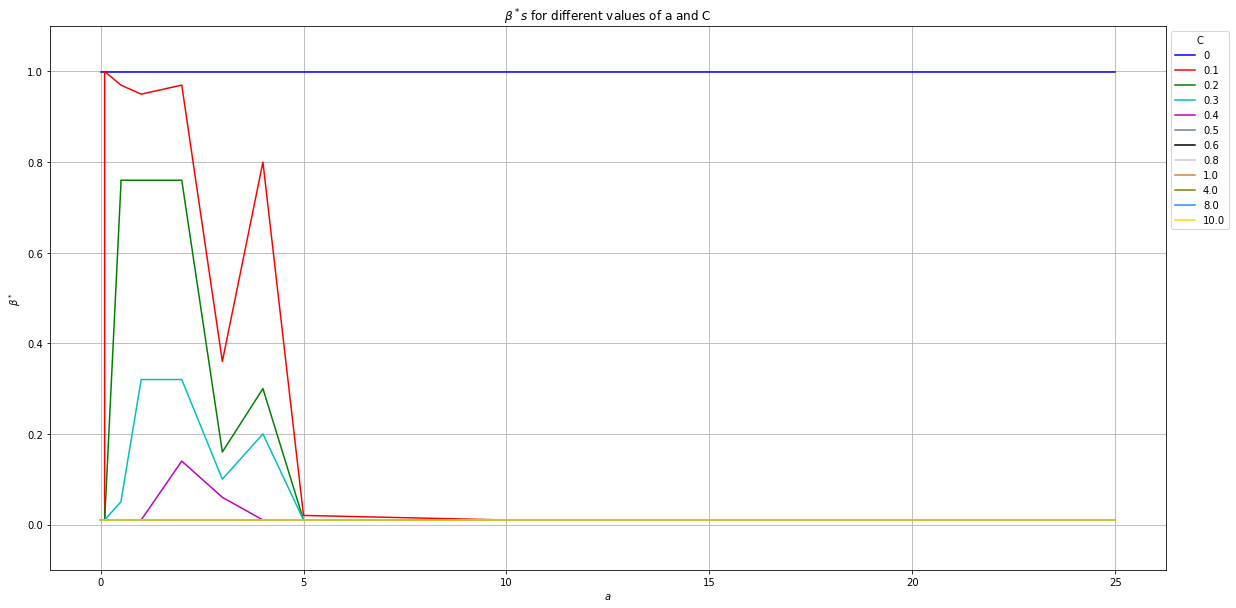

In [30]:
plt.figure(figsize=(20, 10))
color_list = ['b', 'r', 'g', 'c', 'm', 'slategrey', 'k', 'thistle', 'peru', 'olive', 'dodgerblue', 'gold']
for i, C in enumerate(c_s):
  As, Bets = plot_a_beta_C(results=results, C=C)
  plt.plot(As, Bets, label=C, c=color_list[i])
  print('C = ', C)
  print('betas: ', Bets)
  print('as: ', As)
  print('-'*50)
plt.legend(title='C',bbox_to_anchor=(1.0, 1.0))
plt.title(f"$\\beta^*s$ for different values of a and C")
plt.xlabel("$a$")
plt.ylabel("$\\beta^*$")
plt.ylim((-0.1, 1.1))
plt.grid()
plt.show()
plt.show()